On the fly analysis of the Bosphorus Regional in Turkey using the stuff that I've developed so far. Basically an early metric to see if I can predict w/ only a bit of convergence.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dataLoader import load_data_event, normalize_opr
import modelling
import vis

In [2]:
event = 'week3/2020tuis2'
qualification_matches, unplayed_qual_matches, team_scores, team_data, team_component_opr = load_data_event(event)
team_component_opr_normalized = normalize_opr(team_component_opr)

score_prediction_model = modelling.ScoreModelOpr(
    score_model_file='data/saved_models/v1/score-model.json',
    opr_file='data/saved_models/v1/opr-data.csv',
    team_data_file='data/saved_models/v1/team-data.csv'
)

score_prediction_model.oprs = team_component_opr_normalized
score_prediction_model.team_data = team_data

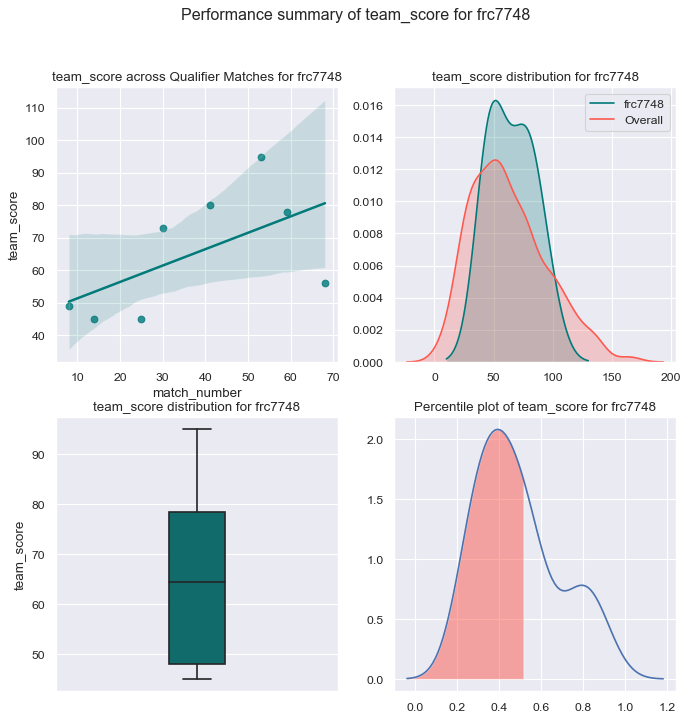

In [15]:
# let's predict all event matches and get a breakdown for the top seeded team
top_key = 'frc7748'
vis.gen_team_summary(top_key, qualification_matches, team_scores, team_data)


In [4]:
# prediction of upcoming match results
vis.predict_matches(score_prediction_model, top_key, unplayed_qual_matches, team_scores)

,match_num,probability,predicted_result
0,59,0.968715,win
1,67,0.850136,lose
2,71,0.990000,lose


In [6]:
# and just to check for the future, let's go ahead and predict the rest of the matches
predictions = score_prediction_model.predict_scores_event(unplayed_qual_matches)
predictions.to_csv('data/saved_predictions/2020tuis2-predictions.csv')

In [10]:
# and now we can compare our predictions to the results to calculate the brier score
predictions = pd.read_csv('data/saved_predictions/2020tuis2-predictions-backup.csv')
# predictions = score_prediction_model.predict_scores_event(qualification_matches)
residuals = []
correct_predictions = total_predictions = 0
for _, match in predictions.iterrows():
    match_candidates = qualification_matches.loc[qualification_matches['match_number'] == match['match_number']]
    if match_candidates.shape[0] > 0:
        actual_match = match_candidates.iloc[0]
        actual_victor = 'red' if actual_match['red_points_scored'] > actual_match['blue_points_scored'] else 'blue'
        if actual_victor == match['predicted_victor']:
            residuals.append(1-match['probability'])
            correct_predictions += 1
        else:
            residuals.append(match['probability'])
        total_predictions += 1
brier = np.mean(np.array(residuals)**2)
percent_correct = correct_predictions / total_predictions
print(f'Brier Score: {brier}')
print(f'Percent Accuracy: {percent_correct}')
# note that these are all based off one-shot predictions made halfway through the tournament

Brier Score: 0.2233534872908423
Percent Accuracy: 0.7142857142857143
